In [7]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input,decode_predictions
from keras.preprocessing import image as img_utils
from keras.layers import Input
import keras.backend as K

# this will contain our generated image
img_size = (224, 224, 3)
input_template = Input(batch_shape=(1,) + img_size)

img_recognition_network = VGG16(input_tensor=input_template, 
                                weights='imagenet', 
                                include_top=True)

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys,os,glob
import numpy as np
sys.path.append('/home/jakub.czakon/deep_learning_art_webinar')
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some random images from the internet

In [10]:
img_filename_list = utils.get_images_from_directory(dir_path='data',
                                                    extensions = ['jpg','jpeg'])

img_list = [img_utils.load_img(f,target_size= img_size[:2]) 
            for f in img_filename_list]
img_tensors_list = [utils.img2vggtensor(im) for im in img_list]

In [11]:
layer_nr = 12
filter_nr = 8
coeff = 0.01
jitter = 15

layer_dict = utils.get_layer_dict(img_recognition_network)

In [12]:
def eval_loss_and_grads(img_tensor,layer_dict,
                       layer_nr,filter_nr,coeff):
  
    x = layer_dict[layer_nr].output[:,:,:,filter_nr]

    loss =  - coeff * K.sum(K.square(x))

    grads = K.gradients(loss, input_template)

    grad_loss_func = K.function([input_template], [loss] + grads)
    
    img_tensor = img_tensor.reshape((1,)+img_size)
    
    outs = grad_loss_func([img_tensor])

    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')

    return loss_value, grad_values

class Evaluator(object):
    def __init__(self,layer_dict,layer_nr,filter_nr,coeff):
        self.loss_value = None
        self.grad_values = None
        self.layer_dict = layer_dict
        self.layer_nr = layer_nr
        self.filter_nr = filter_nr
        self.coeff = coeff

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x,
                                                      self.layer_dict,
                                                      self.layer_nr,
                                                      self.filter_nr,
                                                      self.coeff)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

('Current loss value:', -5199450.0)


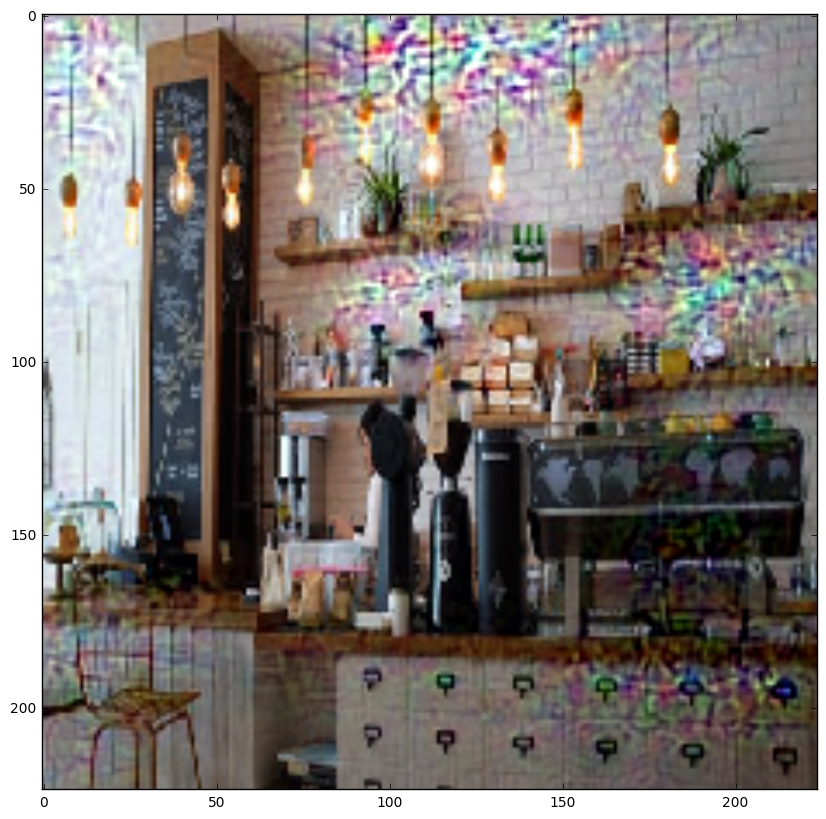

('Current loss value:', -19452764.0)


KeyboardInterrupt: 

In [13]:
from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt

img_dream = img_utils.load_img("resources/shop.jpeg",target_size = img_size[:2])
tens = utils.img2vggtensor(img_dream) 

for i in range(100):
    
    evaluator = Evaluator(layer_dict = layer_dict,
                          layer_nr = layer_nr,filter_nr = filter_nr,
                          coeff = coeff)

    random_jitter = (jitter * 2) * (np.random.random(img_size) - 0.5)

    tens += random_jitter

    tens, min_val, info = fmin_l_bfgs_b(evaluator.loss, tens.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    
    tens = tens.reshape((1,)+img_size)   
    tens -= random_jitter
    img = utils.deprocess_image(np.copy(tens)[0])
    
    plt.imsave(os.path.join("results","shop_{}_{}_{}_{}_{}.jpg".\
                            format(layer_nr,
                                   filter_nr,
                                   coeff,
                                   jitter,
                                   i
                                  )),img)
    
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()